In [76]:
%config InlineBackend.figure_format = 'svg'

```{index} altair
```

(11)=
# Chapter 11: Plotting with Altair

Matplotlib can create nearly any plot you may need, but it often requires numerous lines of code to generate the desired result. Seaborn strives to remedy this by offering functions to create a series of common statistical plots in only a  few lines of code with excellent default colors and styles. Altair strives to be a middle ground by having the power of matplotlib while requiring shorter code than matplotlib. In addition, Altair includes the ability to interact with the plots such as panning, getting stats on highlighted data points, and informative dialogue boxes when hovering the cursor over a data point. While Altair has other virtues, it is the *interactive capabilities* that will be given special attention in this chapter along with teaching the basics of Altair plotting. 

If have Python installed on your machine, you can [install Altair using pip](https://altair-viz.github.io/getting_started/installation.html), and if you are using Colab, Altair is already installed. Altair is imported using the below command with the `alt` alias. Altair is designed to work with pandas, so [pandas](5) needs to also be imported.

In [77]:
import altair as alt
import pandas as pd

Altair has a number of renderers for displaying your plots with the default behavior using a javascript front end that requires an internet connection. If you are working offline or do not want Altair to reach out to the internet to assist in you plotting, the below command will make it work offline. There are other rendering options, but I find this works well while still maintaining the interactivity of Altair plots.

~~~python
alt.renderers.enable('jupyter', offline=True)
~~~

In [78]:
#alt.renderers.enable('png')

RendererRegistry.enable('svg')

```{note}
Some graphs in this chapter are interactive in the web version of this book but are static in the PDF version.
```

(11.1)=
## 11.1 Altair Plotting Basics

In the following example, we will visualize ligand cone angle data from [*J. Am. Chem. Soc.* **1975,** 97, 7, 1955–1956](https://doi.org/10.1021/ja00840a058) and [*Chem. Rev.* **1977,** 77, 3, 313–348](https://doi.org/10.1021/cr60307a002), so the data need to be loaded into a pandas DataFrame.

In [79]:
ligands = pd.read_csv('data/cone_angles.csv', skipfooter=2, engine='python')
ligands.dropna(axis=0, inplace=True) # remove incomplete data rows
ligands.head()

,ligand,dH,cone_angle,CO_freq,type
2,P(OMe)3,-26.4,107,2079.5,P(OR)3
3,P(OCH2CH2Cl)3,-26.4,110,2083.2,P(OR)3
4,PMe3,-26.2,118,2064.1,PR3
5,P(OEt)3,-25.2,109,2076.3,P(OR)3
6,PMe2Ph,-25.0,127,2065.3,PR3


To generate a plot, we first need to create a `Chart` object using the `Chart()` function like below which accepts a pandas DataFrame. Most other customizing beyond this is done by concatenating a series of methods to the `Chart` object. The Chart object then needs to be instructed how to represent data points using one of the mark methods. The table below provides common options, but there are [additional options on the Altair webstie](https://altair-viz.github.io/user_guide/marks/index.html).

**Table 1** Common Altair Marker Methods
|Chart Type | Description |
|:------------------:|:-------------|
|`mark_point()` | Scatter plot  |
|`mark_circle()` | Scatter plot using circle markers |
|`mark_line()` | Line plot |
|`mark_bar()` | Bar plot |
|`mark_rect()` | Heat map | 
|`mark_area()` | Area plot |
|`mark_tick()` | Strip plot |
|`mark_rule()` | Verticle or horizontal line across entire Chart|
|`mark_arc()` | Pie, donut, radial, or polar bar plots |
|`mark_geoshape()` | Generate maps |

The marks are customizable by providing the mark method extra keyword parameters like those listed in Table 2.

**Table 2** Select Mark Method Arguments
|Marker Arguments | Description |
|:---------------:|:-------------|
|`filled=` | Whether marker is filled or not (`True` or `False`) |
|`angle=` | Angle in degrees of marker |
|`opacity=` | Opacity (0 $\rightarrow$ 1) of markers or line |
|`size=` | Size of markers (integer) |
|`color=` | Color (e.g., 'black') of line or marker| 
|`shape=` | [Shape](https://altair-viz.github.io/user_guide/marks/point.html) of marker (e.g., 'triangle', 'square', 'circle', 'cross', 'wedge') 

Below is a function call to make a scatter plot using the `mark_point()` method.

In [80]:
alt.Chart(ligands).mark_point()

Altair only returns a dot because no instructions were provided on how to represent the information. This final piece of information is known as the **encoding** or **encoding channel** and is assigned using the `encode()` method. In the example below, the cone angle is encoded or represented by the location on the *x*-axis using the `x=` parameter and carbonyl (i.e., M-C$\equiv$O) stretching frequency is encoded by the position on the *y*-axis using the `y=` parameter. Because the `Chart` object already has the DataFrame, the `x=` and `y=` arguments only need the DataFrame column names. 

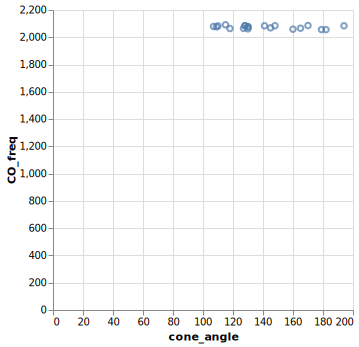

In [81]:
alt.Chart(ligands).mark_point().encode(
    x='cone_angle',
    y='CO_freq')

By default, Altair includes zero on the axes, so it is necessary in this example to adjust the ranges for both axes. To adjust the ranges, first replace the `x=` and `y=` shorthand notation with `alt.X()` and `alt.Y()` which gives more control.

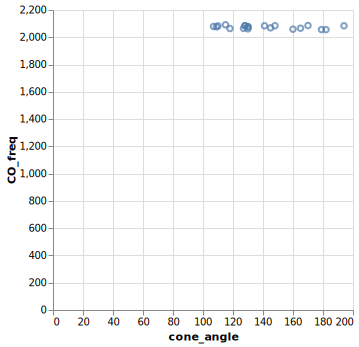

In [82]:
alt.Chart(ligands).mark_point().encode(
    alt.X('cone_angle'),
    alt.Y('CO_freq')
)

Then add the `scale()` method with the `domain=` parameter to restrict the plotting domains.

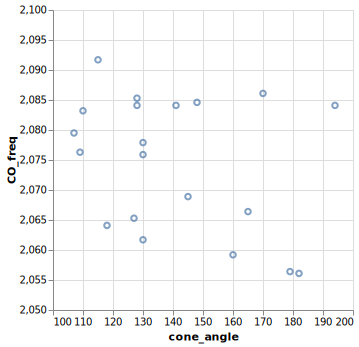

In [83]:
alt.Chart(ligands).mark_point().encode(
    alt.X('cone_angle').scale(domain=[100, 200]),
    alt.Y('CO_freq').scale(domain=[2050, 2100])
)

Along with the *x*- and *y*-axis positions, information can be encoded using other visual indicators such as color, size, shape, etc. Below is a table of some key encodings with others listed on the [Altair website](https://altair-viz.github.io/user_guide/encodings/channels.html#user-guide-encoding-channels).

**Table 3** Common Encoding Channels in Altair
|Encoding | Description |
|:----------------:|:-------------|
|`x` or `alt.X()` | Position on *x*-axis  |
|`y` or `alt.Y()` | Position on *y*-axis |
|`color` or `alt.Color()` | Marker color |
|`shape` or `alt.Shape()` | Marker shape |
|`size` or `alt.Size()` | Marker size | 
|`opacity` or `alt.Opacity()` | Opacity of the marker |
|`column` or `alt.Column()`| Separates plots along *x*-axis |
|`row` or `alt.Row()` | Separates plots along *y*-axis | 
|`tooltip` | Dialogue box with information |

For example, the chart below represents the $\Delta$H values using the color and the type of ligand with the marker shape.

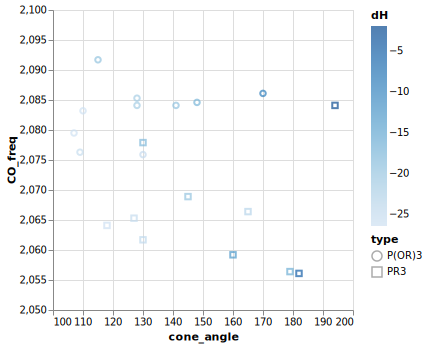

In [84]:
alt.Chart(ligands).mark_point().encode(
    alt.X('cone_angle').scale(domain=[100, 200]),
    alt.Y('CO_freq').scale(domain=[2050,2100]),
    alt.Color('dH'),
    alt.Shape('type')
)

Another way to provide access to information is through a dialogue box using the `tooltip=` encoding parameter. Just include a list or tuple of DataFrame column names to be included in the tooltip box. Below, the user will see a small popup box with the ligand name, enthalpy, and carbonyl frequencies whenever they hover their cursor over the marker on the plot.

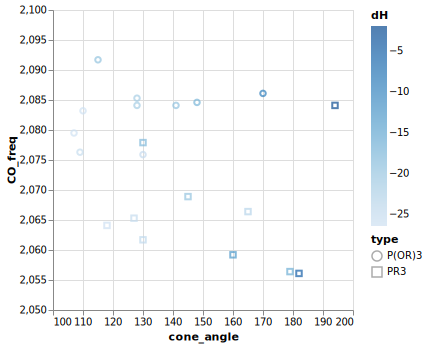

In [85]:
alt.Chart(ligands).mark_point().encode(
    alt.X('cone_angle').scale(domain=[100, 200]),
    alt.Y('CO_freq').scale(domain=[2050,2100]),
    alt.Color('dH'),
    alt.Shape('type'), 
    tooltip=['ligand', 'dH', 'CO_freq']
)

We now have a fairly reasonable plot, but further customization is often necessary. For example, better axis labels with units would be ideal and can be added using the `title()` method on each encoding channel. If you don't like the colormap, this can be set with the `scheme=` argument in the color encoding channel.

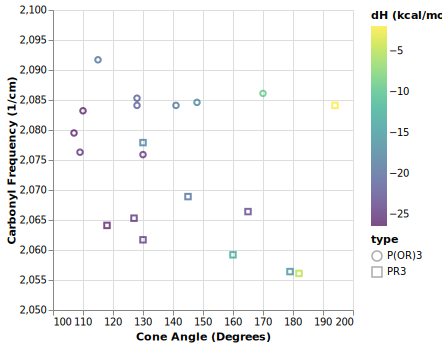

In [86]:
alt.Chart(ligands).mark_point().encode(
    alt.X('cone_angle').scale(domain=[100, 200]).title('Cone Angle (Degrees)'),
    alt.Y('CO_freq').scale(domain=[2050,2100]).title('Carbonyl Frequency (1/cm)'),
    alt.Color('dH').scale(scheme='viridis').title('dH (kcal/mol'),
    alt.Shape('type'),
    tooltip=['ligand', 'dH', 'CO_freq']
)

```{tip}
If you get an error while trying to save your plot, you may be missing an optional dependancy. See [Altair website](https://altair-viz.github.io/getting_started/installation.html) for installation instructions.
```

As a final step for our first Altair plot, we can save it using either the (...) menu on the top right or by using the `save()` method. Like matplotlib, if no format is specified, Altair grabs this information from the extension (e.g., png, pdf, or svg) in the file name.

In [87]:
c = alt.Chart(ligands).mark_point().encode(
        alt.X('cone_angle').scale(domain=[100, 200]).title('Cone Angle (Degrees)'),
        alt.Y('CO_freq').scale(domain=[2050,2100]).title('Carbonyl Frequency (Wavenumbers)'),
        alt.Color('dH').scale(scheme='viridis').title('dH (kcal/mol)'),
        alt.Shape('type')
)
c.save('first_altair_plot.pdf', format='pdf')

```{index} single: interactivity ; pan and zoom
```

(11.2)=
## 11.2 Panning & Zooming with `interactive()`

One of the major advantages of Altair over seaborn and matplotlib is the ability to interact with plots in Altair. This can take many forms, the most basic of which is the ability to pan and zoom. Enabled panning and zooming by adding the `interactive()` method to a `Chart` object. Now by dragging and scrolling, the user can pan and zoom the plot, respectively. Double click on the plot to reset it.

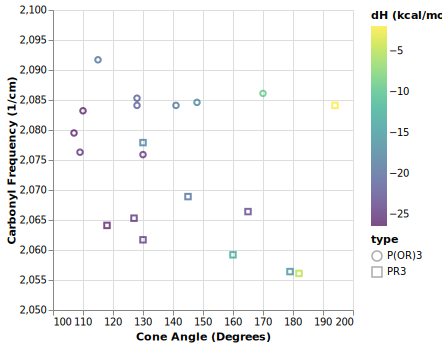

In [88]:
alt.Chart(ligands).mark_point().encode(
    alt.X('cone_angle').scale(domain=[100, 200]).title('Cone Angle (Degrees)'),
    alt.Y('CO_freq').scale(domain=[2050,2100]).title('Carbonyl Frequency (1/cm)'),
    alt.Color('dH').scale(scheme='viridis').title('dH (kcal/mol'),
    alt.Shape('type')
).interactive()

As an additional example, we will plot the IR spectrum of *trans*-cinnamaldehyde. Because this is a spectrum, a line plot is the most appropriate.

````{margin}
```{tip}
There are often larger numbers of data points in spectral data. If you get an error due to too many data points, you can add `alt.data_transformers.disable_max_rows()` to override this if need be. You may also run `alt.data_transformers.enable("vegafusion")` which does some pre-calculations.
```
````

In [89]:
# load IR data of trans-cinnamaldehyde
tcinn = pd.read_csv('data/tcinn.CSV', delimiter=',', header=None)
tcinn.columns = ['Wavenumbers', 'Absorbance']
tcinn = tcinn.round({'Wavenumbers': 1, 'Absorbance': 2})

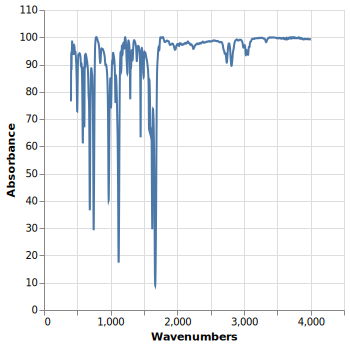

In [90]:
alt.data_transformers.enable("vegafusion")
alt.Chart(tcinn).mark_line().encode(
    x='Wavenumbers',
    y='Absorbance'
)

We now see our plot, but it's a bit tiny for an IR spectrum. The plot size can be adjusted using the `properties()` method and with the `width=` and `height=` arguments.

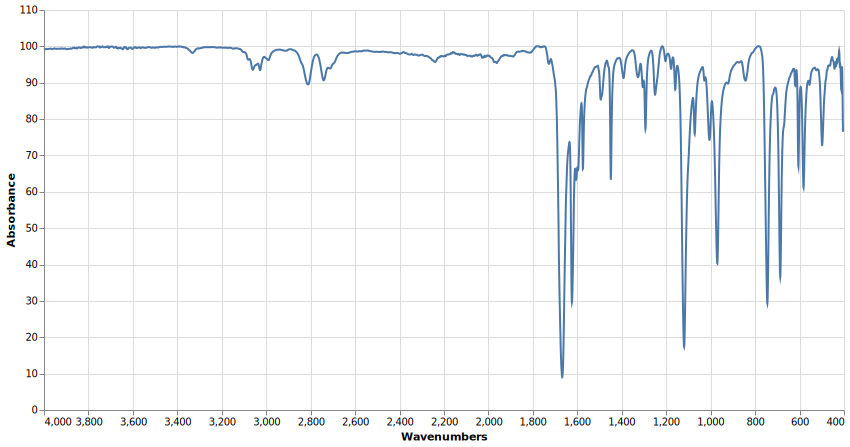

In [91]:
alt.Chart(tcinn).mark_line().encode(
    alt.X('Wavenumbers').scale(domain=(4000, 400)),
    y='Absorbance'
).properties(width=800, height=400)

The *x*-axis can be reversed by either setting the `domain=(14, -1)` or by setting `reverse=True` in the `scale()` method. The plot below is also made interactive by again appending `.interactive()` and adding a `tooltip`. The nice thing about making a spectrum interactive is the ability to pan, zoom, and identify the frequencies of various absorbances.

````{margin}
```{note}
One disadvantage of Altair is that the axis labels do not currently support Latex formatting. For now, paste in unicode symbols whenever you need them.
```
````

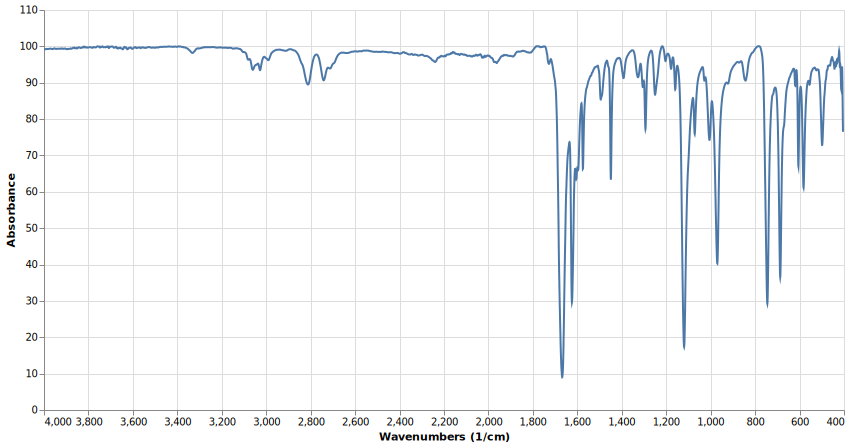

In [92]:
alt.Chart(tcinn).mark_line().encode(
    alt.X('Wavenumbers').scale(domain=(4000, 400)).title('Wavenumbers (1/cm)'),
    y='Absorbance',
    tooltip=['Wavenumbers', 'Absorbance']
).properties(width=800, height=400).interactive()

(11.3)=
## 11.3 Data Types

Altair will make a best effort to guess the data type (Table 4) and plot the data appropriately. For example, if the data are numerical values, Altair treats the values as continuous quantitative features, so it plots the data along a continuous axis with markings anywhere along the axis. Alternatively, if the data are strings, Altair treats them as nominal data which is categorical in no particular order. 

**Table 4** Altair Data Types 
| Data Type | Abbreviation | Description | Examples | 
| :-----:  | :----: | :---------  | ------------|
| Quantitative | `:Q` | Continuous numerical data | Densities or chemical shift |
| Nominal | `:N` | Unordered, non-continuous data | Glassware type or functional group |
| Ordinal | `:O` | Ordered, non-continuous data | Months or degree of alcohol |
| Time | `:T` | Date or time values | Date/Time data was collected | 
| Geojson | `:G` | Geographical information | Location sample was collected or country of origin | 

For example, when plotting the molecular weight (`MW`) versus hydrocarbon type (`hydrocarbon`), Altair automatically treats the molecular weight as quantitative data and the hydrocarbon type as nominal data like below.

In [93]:
HC = pd.read_csv('data/hydrocarbon.csv')
HC.head()

,bp,MW,EOU,hydrocarbon
0,574.0,238.46,1,alkene
1,356.0,82.15,2,alkene
2,565.0,226.45,0,alkane
3,330.0,82.15,2,alkyne
4,457.0,156.31,0,alkane


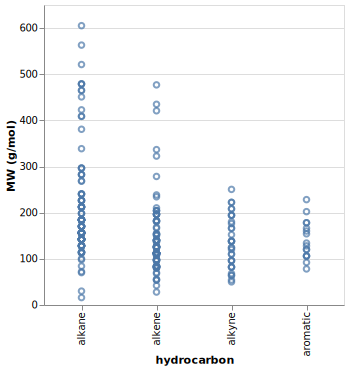

In [94]:
alt.Chart(HC).mark_point().encode(
    alt.X('hydrocarbon'),
    alt.Y('MW').title('MW (g/mol)')
).properties(width=300)

The default data types can be overridden by either appending the data type abbreviation (Table 4) to the DataFrame header string or by setting `type=` to one of the types. One common situation where this is necessary is when categories are designated by numbers like in machine learning datasets. For example, the hydrocarbon data includes the elements of unsaturation (`EOU`) for various hydrocarbons. Altair's default behavior is to treat the degree as continuous and quantitative which leads to the following result.

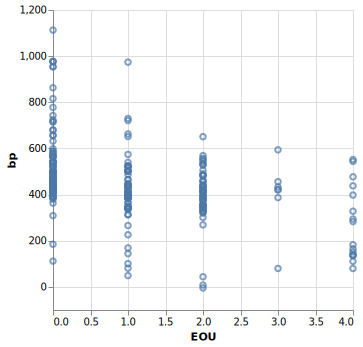

In [95]:
low_EOU = HC[HC['EOU'] <= 4]

alt.Chart(low_EOU).mark_point().encode(
    alt.X('EOU'),
    alt.Y('bp'))

This is not really what we want because there are non-integer markings and the 4 is up against the edge of the plot. If we append `:O` to the `EOU`, this tells Altair to treat elements of unsaturation is nominal values, which are ordered but not continuous.

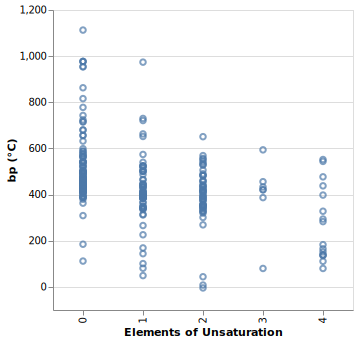

In [96]:
alt.Chart(low_EOU).mark_point().encode(
    alt.X('EOU:O').title('Elements of Unsaturation'),
    alt.Y('bp').title('bp (°C)')
).properties(width=300)

Alternatively, we can add `type='ordinal'` to get the same result.

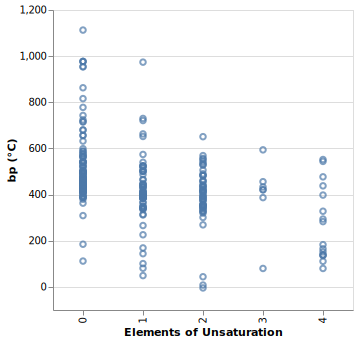

In [97]:
alt.Chart(low_EOU).mark_point().encode(
    alt.X('EOU', type='ordinal').title('Elements of Unsaturation'),
    alt.Y('bp').title('bp (°C)')
).properties(width=300)

Now we only get integer markings while the values are still in order. 

The chart can be further customized like changing the angle of the axis labels, colors and shape or markers, and making the chart interactive.

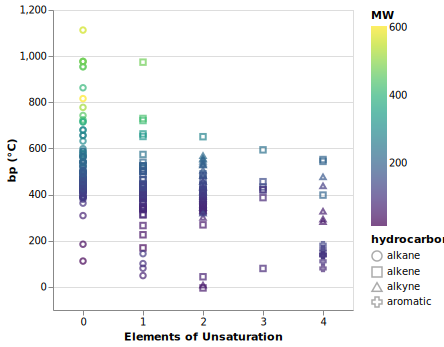

In [98]:
alt.Chart(low_EOU).mark_point().encode(
    alt.X('EOU:O', axis=alt.Axis(labelAngle=0)).title('Elements of Unsaturation'),
    alt.Y('bp').title('bp (°C)'),
    alt.Color('MW').scale(scheme='viridis'),
    alt.Shape('hydrocarbon')
).properties(width=300).interactive()

(11.4)=
## 11.4 Multifigure Plotting

Altair supports the display of faceted figures. While the figures could be created using separate code cells, there are advantages to displaying them together (see [section 11.5](11.5)). In this example, we will display the density of degassed Coke and Diet Coke using different types of glassware for measuring the volume.

In [99]:
soda = pd.read_csv('data/soda.csv')
soda.head()

,Density,Glassware,Soda
0,1.00,Grad Cylinder,Coke
1,1.00,Grad Cylinder,Coke
2,0.99,Grad Cylinder,Coke
3,1.00,Grad Cylinder,Coke
4,0.98,Grad Cylinder,Coke


In the first example below, we use the `Column` encoding to represent the data for different glassware types. This results in what looks like three different figures that share the same *y*-axis label. If we were to instead used `Row` encoding, the three sections would instead be rows and share the same *x*-axis label.

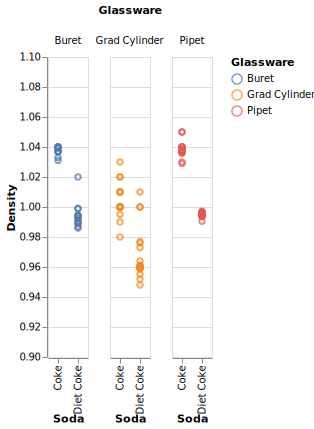

In [100]:
alt.Chart(soda).mark_point().encode(
    alt.Y('Density').scale(domain=(0.9, 1.1)),
    alt.Column('Glassware'),
    x='Soda',
    color='Glassware')

This figure is a bit narrow, so we can adjust the dimensions again using `.properties(width=100)` which sets the width of each section of the graph.

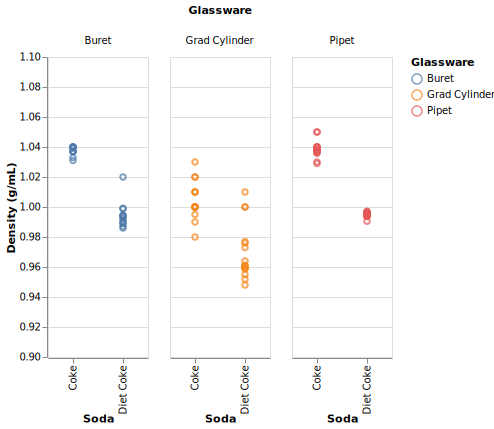

In [101]:
alt.Chart(soda).mark_point().encode(
    alt.Y('Density').title('Density (g/mL)').scale(domain=(0.9, 1.1)),
    x='Soda',
    column='Glassware',
    color='Glassware').properties(width=100)

Another way to generate two or more figures or plots together is to concatenate or overlay them. This is accomplished by assigning two different charts to variables and using either `&`, `|`, or `+` (Table 5). Alternatively, the functions in Table 5 can be used by providing them with the Chart objects.

**Table 5** Layered and Multifigured Plots

| Operator | Function |Description |
|:--------:|:----------|:------------|
| `\|` | `alt.hconcat()` |Horizontal concatenation |
| `&` | `alt.vconcat()` |Vertical concatenation |
|`+`  | `alt.layer()` |Overlay two plots |

Below, two scatter plots are created with density on the *y*-axis and different categories on the *x*-axes. The figures are then horizontally concatenate.

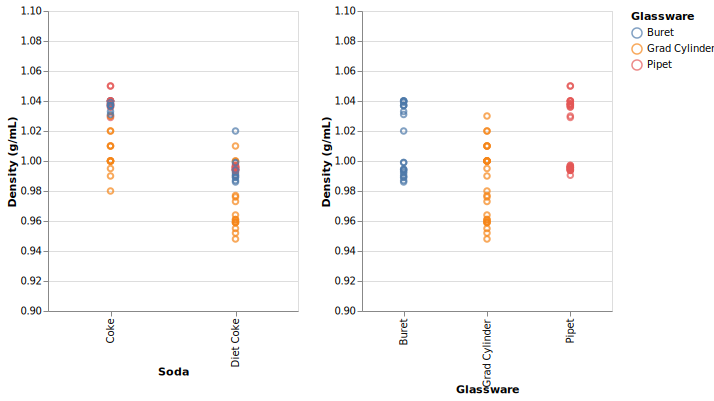

In [102]:
chart1 = alt.Chart(soda).mark_point().encode(
            alt.Y('Density').title('Density (g/mL)').scale(domain=(0.9, 1.1)),
            x='Soda',
            color='Glassware').properties(width=250)

chart2 = alt.Chart(soda).mark_point().encode(
            alt.Y('Density').title('Density (g/mL)').scale(domain=(0.9, 1.1)),
            x='Glassware',
            color='Glassware').properties(width=250)

chart1 | chart2

We could instead perform vertical concatenation like below. This is more useful when one plot is narrow like a small bar graph.

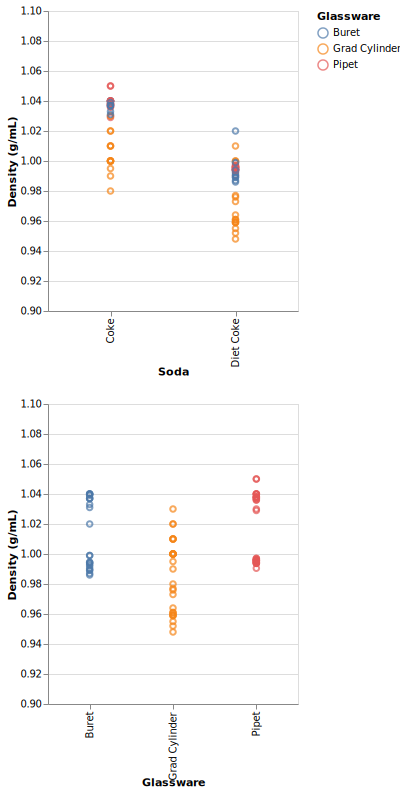

In [103]:
chart1 = alt.Chart(soda).mark_point().encode(
            alt.Y('Density').title('Density (g/mL)').scale(domain=(0.9, 1.1)),
            x='Soda',
            color='Glassware').properties(width=250)

chart2 = alt.Chart(soda).mark_point().encode(
            alt.Y('Density').title('Density (g/mL)').scale(domain=(0.9, 1.1)),
            x='Glassware',
            color='Glassware').properties(width=250)

chart1 & chart2

The overlay option (`+`) is useful for plotting more than one type of plot on the same axes like a line and scatter plot as we have often done in [chapter 3](3). An example of this is in the following section.

```{index} single: interactivity ; selection
```

(11.5)=
## 11.5 Interactive Selections

Another form of interactivity supported by Altair is to allow the user to select portions of a graph and see information about the selection such as averages, sums, and distributions. For this section, we will start by looking at a dataset with alcohol machine learning features.

In [104]:
ROH = pd.read_csv('data/ROH_data.csv')
ROH.head()

,bp,MW,carbons,degree,aliphatic,avg_aryl_position,cyclic
0,338,32.04,1,1,1,0.0,0
1,351,46.07,2,1,1,0.0,0
2,371,60.10,3,1,1,0.0,0
3,356,60.10,3,2,1,0.0,0
4,391,74.12,4,1,1,0.0,0


Below, the boiling point, molecular weight, degree, and whether the alcohol is cyclic (`1`) or non-cyclic (`0`) are visualized.

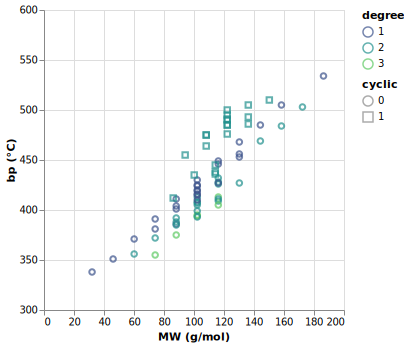

In [105]:
alt.Chart(ROH).mark_point().encode(
    alt.Y('bp').scale(domain=[300, 600]).title('bp (°C)'),
    alt.X('MW').scale(domain=[0, 200]).title('MW (g/mol)'),
    alt.Color('degree:O').scale(scheme='viridis'),
    alt.Shape('cyclic:N'))

Altair allows the users to box select data points by adding an interval selection parameter using the `alt.selection_interval()` function. This selection parameter is added to the Chart through the `.add_params()` method. By default, this is a box selection which allows the user to select a rectangle anywhere on the plot. If `encodings=['x']` or `encodings=['y']` parameters are added to the `selection_interval()` function, the selection is restricted along the *x*- or *y*-axes, respectively.

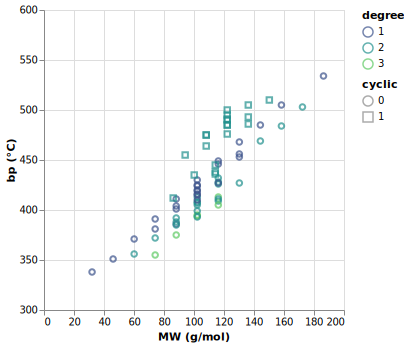

In [106]:
# box selection
selection = alt.selection_interval()

points = alt.Chart(ROH).mark_point().encode(
    alt.Y('bp').scale(domain=[300, 600]).title('bp (°C)'),
    alt.X('MW').scale(domain=[0, 200]).title('MW (g/mol)'),
    alt.Color('degree:O').scale(scheme='viridis'),
    alt.Shape('cyclic:N')
).add_params(selection)

points

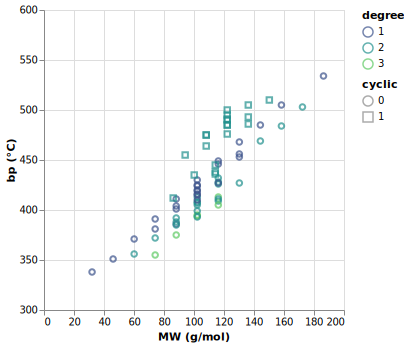

In [107]:
# X selection object
selection = alt.selection_interval(encodings=['x'])

points = alt.Chart(ROH).mark_point().encode(
    alt.Y('bp').scale(domain=[300, 600]).title('bp (°C)'),
    alt.X('MW').scale(domain=[0,200]).title('MW (g/mol)'),
    alt.Color('degree:O').scale(scheme='viridis'),
    alt.Shape('cyclic:N')
).add_params(selection)

points

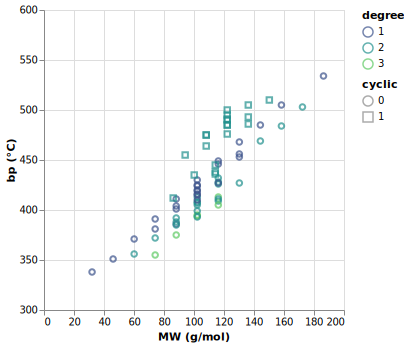

In [108]:
# Y selection object
selection = alt.selection_interval(encodings=['y'])

points = alt.Chart(ROH).mark_point().encode(
    alt.Y('bp').scale(domain=[300, 600]).title('bp (°C)'),
    alt.X('MW').scale(domain=[0,200]).title('MW (g/mol)'),
    alt.Color('degree:O').scale(scheme='viridis'),
    alt.Shape('cyclic:N')
).add_params(selection)

points

The user is now able to select regions of the Chart, which is stored in the `selection` variable. This does not really do anything except make a gray box until this information is passed to another function. In the plot below, two Chart objects are created - one scatter plot and one bar plot. These Charts are vertically concatenated using the `&` operator (last line). The selection object is added to the scatter plot using `add_params()` while the selection object is provided to the bar plot through the `transform_filter()` function. This setup makes it so the scatter plot is where the user selects regions and the bar plot is the recipient of this selection information. Finally, notice that the bar plot *x*-variable contains a `count()` function instead of a DataFrame column header. This processes the selection information and uses it for the bar graph. Specifically, the bar graph here shows the total number of primary, secondary, and tertiary alcohols selected in the scatter plot.

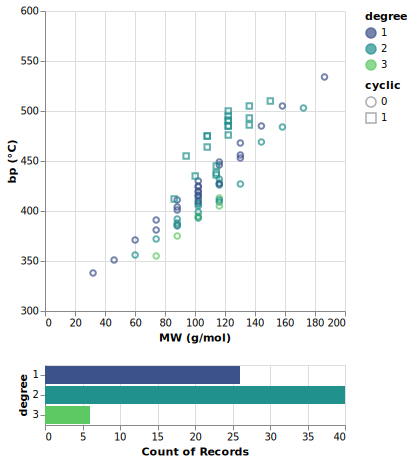

In [109]:
# box and bar select together
selection = alt.selection_interval()

# scatter plot
scatter = alt.Chart(ROH).mark_point().encode(
    alt.Y('bp').scale(domain=[300, 600]).title('bp (°C)'),
    alt.X('MW').scale(domain=[0,200]).title('MW (g/mol)'),
    alt.Color('degree:O').scale(scheme='viridis'),
    alt.Shape('cyclic:N')
).add_params(selection)

# bar plot
bar = alt.Chart(ROH).mark_bar().encode(
    x='count()',
    y='degree:O',
    color='degree:O'
).transform_filter(selection)

# stack scatter and bar plot
scatter & bar

Another example below is a bar graph of the radial probability of the hydrogen 3p atomic orbital. Like above, there are two Chart objects - one bar graph and a rule or line that spans the entire Chart. Instead of stacking these Charts, they are overlayed using the `+` operator. The bar graph is provided the selection object through the `add_params()` method allowing the user to select regions in this Chart. The rule Chart accepts the selection through the `transform_filter()` method making it the recipient of the selection information. Similar to the above example, the *y*-axis is given a function, `mean()`, which takes the average of the selected probabilities and sets the horizontal bar to this value. The end result is a bar plot where the user can select a region and see a horizontal line marking the average probability of the selected region.

```{index} single: orbitals; graphical integration
```

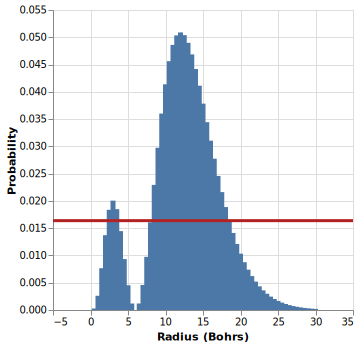

In [110]:
prob = pd.read_csv('data/prob_3p_normalized.csv')

selection = alt.selection_interval(encodings=['x'])

bar = alt.Chart(prob).mark_bar().encode(
    x=alt.X('Radius').title('Radius (Bohrs)'),
    y=alt.Y('Probability').title('Probability'),
).add_params(selection)

rule = alt.Chart(prob).mark_rule(color='firebrick').encode(
    y='mean(Probability)',
    size=alt.SizeValue(3)
).transform_filter(selection)

bar + rule

Below is a modified version of the previous graphic where instead of taking the mean of the selected region, the sum is calculated. This effectively allows the user to graphically integrate different regions of the graph. For example, by selecting the region just below the node, it can be seen that this region constitutes a little over 10% of the probability.

The two Charts are overlayed using the `alt.layer()` function instead of the `+` operator to allow more control. This allows a second *y*-axis to be added, which shows the sum of the selected probabilities. The colors of the two *y*-axis labels are also set to match the two elements in the plot.

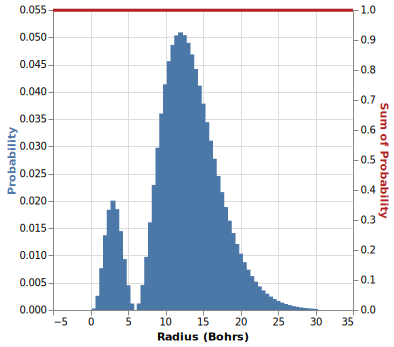

In [111]:
selection = alt.selection_interval(encodings=['x'])

bar = alt.Chart(prob).mark_bar().encode(
    x=alt.X('Radius').title('Radius (Bohrs)'),
    y=alt.Y('Probability').axis(title='Probability', titleColor='#5276A7'),
).add_params(selection)

rule = alt.Chart(prob).mark_rule(color='firebrick').encode(
    y=alt.Y('sum(Probability)').scale(domain=(0, 1)).axis(titleColor='firebrick'),
    size=alt.SizeValue(3)
).transform_filter(
    selection
)

alt.layer(bar, rule, data=prob).resolve_scale(y='independent')

Finally, the above plot can be converted from a bar graph to a line plot by changing `mark_bar()` to `mark_line()`.

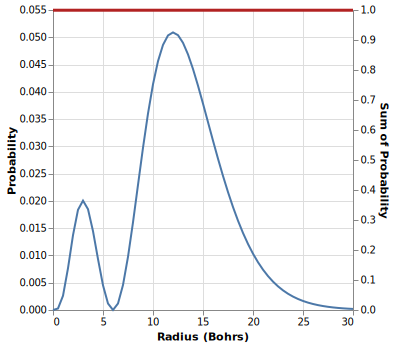

In [112]:
selection = alt.selection_interval(encodings=['x'])

bar = alt.Chart(prob).mark_line().encode(
    x=alt.X('Radius').title('Radius (Bohrs)'),
    y=alt.Y('Probability').title('Probability'),
).add_params(selection)

rule = alt.Chart(prob).mark_rule(color='firebrick').encode(
    y=alt.Y('sum(Probability)').scale(domain=(0, 1)),
    size=alt.SizeValue(3)
).transform_filter(
    selection
)

alt.layer(bar, rule, data=prob).resolve_scale(y='independent')

(fr11)=
## Further Reading

The best source of up-to-date information on Altair is the Altair website. Because Altair is newer than matplotlib and seaborn, there are fewer resources currently available.

1. Altair website. [https://altair-viz.github.io/](https://altair-viz.github.io/) (free resource)
   > Official Altair website and documentation page.